# 2. Data Cleaning

Before feeding the dataset to the dimensionality reduction and clustering algorithms, it must be cleaned.  
This notebook contains:

1. Cleaning steps
2. Assumptions about the data
3. Modeling decisions
4. First approach to feature selection by dealing with missing values

For modeling refer to the notebook: __3_OSMI_EDA.ipynb__ 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

import os
from pathlib import Path
from dotenv import load_dotenv

from sklearn.impute import SimpleImputer

In [2]:
load_dotenv(Path().cwd().parent.joinpath(".env"))

True

In [3]:
# Dataset location
LOCATION_DATSET = Path(os.getenv("LOCATION_DATASET"))

In [4]:
df = pd.read_csv(LOCATION_DATSET)
n_participants, n_questions = df.shape
print(f"Survey is composed of\nParticipants = {n_participants}\nQuestions = {n_questions}")

Survey is composed of
Participants = 1433
Questions = 63


In [5]:
df.head()

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a menta

# Data Cleaning

## 1. How many people did not answer the majority of the questions

In [6]:
# 20 people did not answer 50% or more of the survey
# These pariticpants can be discarded
print(((df.isna().sum(axis=1) / n_questions) >= 0.5).sum())

20


In [7]:
df = df.loc[(df.isna().sum(axis=1) / n_questions) <= .5,:]
df

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a menta

## 2. Dealing with the most unanswered questions.

In [8]:
# what is the proportion of missing values we are dealing with? --> See 1. OSMI_overview
missing_values = df.isna().sum() / len(df)

In [9]:
# All features that have more than 50% of missing values will be discarded
questions_to_drop = missing_values[missing_values > 0.5].index.tolist()
questions_to_drop

['Is your primary role within your company related to tech/IT?',
 'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?',
 'Do you know local or online resources to seek help for a mental health disorder?',
 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
 'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
 'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?',
 'Do you believe your productivity is ever affected by a mental health issue?',
 'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
 'Ha

In [10]:
df = df.drop(columns=questions_to_drop)
df.shape

(1413, 51)

In [11]:
# possible categories per question
# How many unique answers? This will help find the questions with non-standarized questions
df.nunique()

Are you self-employed?                                                                                                                               2
How many employees does your company or organization have?                                                                                           6
Is your employer primarily a tech company/organization?                                                                                              2
Does your employer provide mental health benefits as part of healthcare coverage?                                                                    4
Do you know the options for mental health care available under your employer-provided coverage?                                                      3
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?               3
Does your employer offer resources to learn more about mental health concerns and options for 

In [12]:
# These two questions are open, so the answers are always very different, 80% of them are answered so they might contain interesting information.
# We extract them into different variables to do a separate analysis later - TODO: sentiment analysis? Bag of Word to check which word are most frequent
# indexes are kept to be able to identify participants later in the clusters
# main question: Would you be willing to bring up a physical health issue with a potential employer in an interview?
# secondary:
DATA_UTILS = Path(os.getenv("DATA_UTILS"))
willingness_to_bring_up_physical_issue = df.loc[:,"Why or why not?"]
willingness_to_bring_up_physical_issue.to_csv(DATA_UTILS.joinpath("willingness_to_bring_up_physical_issue.csv"), sep=";")

In [13]:
# main questions: Would you bring up a mental health issue with a potential employer in an interview?
willingness_to_bring_up_mentall_issue = df.loc[:,"Why or why not?.1"]
willingness_to_bring_up_mentall_issue.to_csv(DATA_UTILS.joinpath("willingness_to_bring_up_mental_issue.csv"), sep=";")

In [14]:
# Sanity check
df = df.drop(columns=["Why or why not?", "Why or why not?.1"])
df.nunique()

Are you self-employed?                                                                                                                              2
How many employees does your company or organization have?                                                                                          6
Is your employer primarily a tech company/organization?                                                                                             2
Does your employer provide mental health benefits as part of healthcare coverage?                                                                   4
Do you know the options for mental health care available under your employer-provided coverage?                                                     3
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?              3
Does your employer offer resources to learn more about mental health concerns and options for seekin

In [15]:
n_participants, n_questions = df.shape
print(f"Survey is composed of\nParticipants = {n_participants}\nQuestions = {n_questions}")

Survey is composed of
Participants = 1413
Questions = 49


## 2. Cleaning specific questions
### Gender
To facilitate the analysis, all answere were classified in three different groups: male, female, non-binary.  
This solely with the purpose facilitate the analysis it does not intent to under represent any specific gender.

In [16]:
# Dealing with specific questions
gender = df.loc[:, "What is your gender?"].copy()
gender = gender.str.lower()
gender = gender.str.strip()
gender_list = gender.unique().tolist()
gender_list

['male',
 'female',
 'm',
 'i identify as female.',
 'bigender',
 'non-binary',
 'female assigned at birth',
 'f',
 'woman',
 'man',
 'fm',
 'cis female',
 'transitioned, m2f',
 'genderfluid (born female)',
 'other/transfeminine',
 'female or multi-gender femme',
 'female/woman',
 'cis male',
 'male.',
 'androgynous',
 'male 9:1 female, roughly',
 nan,
 'male (cis)',
 'other',
 'nb masculine',
 'cisgender female',
 'sex is male',
 'none of your business',
 'genderqueer',
 'human',
 'genderfluid',
 'enby',
 'malr',
 'genderqueer woman',
 'mtf',
 'queer',
 'agender',
 'dude',
 "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?",
 'mail',
 'm|',
 'male/genderqueer',
 'fem',
 'nonbinary',
 'female (props for making this a freeform field, though)',
 'unicorn',
 'male (trans, ftm)',
 'cis-woman',
 'cisdude',
 'genderflux demi-girl',
 'female-bodied; no feelings about gender',
 'cis man'

In [17]:
non_binary = [
    'bigender',
    'non-binary',
    'transitioned, m2f',
    'genderfluid (born female)',
    'other/transfeminine',
    'androgynous',
    'male 9:1 female, roughly',
    'other',
    'nb masculine',
    'none of your business',
    'genderqueer',
    'human',
    'genderfluid',
    'enby',
    'genderqueer woman',
    'mtf',
    'queer',
    'agender',
    'fluid',
    'male/genderqueer',
    'fem',
    'nonbinary',
    'unicorn',
    'male (trans, ftm)',
    'genderflux demi-girl',
    'transgender woman',
    'afab',
    'female assigned at birth',
    'female-bodied; no feelings about gender'
]

In [18]:
gender = gender.apply(lambda x : "non-binary" if x in non_binary else x)
gender

0             male
1             male
2             male
3             male
4           female
           ...    
1428        female
1429          male
1430          male
1431        female
1432    non-binary
Name: What is your gender?, Length: 1413, dtype: object

In [19]:
gender.unique().tolist()

['male',
 'female',
 'm',
 'i identify as female.',
 'non-binary',
 'f',
 'woman',
 'man',
 'fm',
 'cis female',
 'female or multi-gender femme',
 'female/woman',
 'cis male',
 'male.',
 nan,
 'male (cis)',
 'cisgender female',
 'sex is male',
 'malr',
 'dude',
 "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?",
 'mail',
 'm|',
 'female (props for making this a freeform field, though)',
 'cis-woman',
 'cisdude',
 'cis man']

In [20]:
binary = {
    'm' : 'male',
    'i identify as female.' : 'female',
    'f' : 'female',
    'woman' : 'female',
    'man' : 'male',
    'fm' : 'female',
    'cis female' : 'female',
    'female or multi-gender femme' : 'female',
    'female/woman' : 'female',
    'cis male' : 'male',
    'male.' : 'male',
    'male (cis)' : 'male',
    'cisgender female' : 'female',
    'sex is male' : 'male',
    'malr' : 'male',
    'dude' : 'male',
    "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?" : 'male',
    'mail' : 'male',
    'm|' : 'male',
    'female (props for making this a freeform field, though)' : 'female',
    'cis-woman' : 'female',
    'cisdude' : 'male',
    'cis man' : 'male'
}

In [21]:
gender = gender.replace(binary)
gender

0             male
1             male
2             male
3             male
4           female
           ...    
1428        female
1429          male
1430          male
1431        female
1432    non-binary
Name: What is your gender?, Length: 1413, dtype: object

In [22]:
gender.unique()

array(['male', 'female', 'non-binary', nan], dtype=object)

In [23]:
df["What is your gender?"] = gender

In [24]:
# Sanity check
# Compare unique answers with nans and without nans. What other questions requieres especial attention?
unique_vals_with_nan = df.nunique(dropna=False)
unique_vals_with_nan.name = "with_nan"

unique_vals_without_nan = df.nunique(dropna=True)
unique_vals_without_nan.name = "without_nan"

pd.merge(unique_vals_with_nan, unique_vals_without_nan, left_index=True, right_index=True)

,with_nan,without_nan
Are you self-employed?,2,2
How many employees does your company or organization have?,7,6
Is your employer primarily a tech company/organization?,3,2
Does your employer provide mental health benefits as part of healthcare coverage?,5,4
Do you know the options for mental health care available under your employer-provided coverage?,4,3
"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",4,3
Does your employer offer resources to learn more about mental health concerns and options for seeking help?,4,3
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,4,3
"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",7,6
Do you think that discussing a mental health disorder with your employer would have negative consequences?,4,3


### Country of residence

In [25]:
# Exchange country names by the ISO 3166 encoding to have a unified representation and avoid special characters in country names
countries = df["What country do you live in?"].value_counts(dropna=False)
countries

What country do you live in?
United States of America    836
United Kingdom              176
Canada                       77
Germany                      54
Netherlands                  47
Australia                    35
Sweden                       19
France                       15
Ireland                      14
Brazil                       10
Switzerland                  10
Russia                        9
New Zealand                   9
India                         9
Denmark                       7
Bulgaria                      7
Finland                       7
Belgium                       5
Italy                         5
Spain                         4
Austria                       4
South Africa                  4
Pakistan                      3
Norway                        3
Poland                        3
Romania                       3
Chile                         3
Czech Republic                2
Bosnia and Herzegovina        2
Mexico                        2
Lithuania  

In [26]:
# replace country names with their iso code
COUNTRY_CODES = Path(os.getenv("COUNTRY_CODES"))
country_codes = pd.read_csv(COUNTRY_CODES, sep=";", encoding="utf-8").set_index("country")
country_codes.head()

,code
country,
Aruba,ABW
Afghanistan,AFG
Angola,AGO
Anguilla,AIA
Åland Islands,ALA


In [27]:
df["What country do you live in?"] = df["What country do you live in?"].map(lambda x : country_codes.loc[x].values[0] if x in country_codes.index else x)
df["What country do you live in?"].value_counts()

What country do you live in?
USA      836
GBR      176
CAN       77
DEU       54
NLD       47
AUS       35
SWE       19
FRA       15
IRL       14
BRA       10
CHE       10
RUS        9
NZL        9
IND        9
DNK        7
BGR        7
FIN        7
BEL        5
ITA        5
ESP        4
AUT        4
ZAF        4
PAK        3
NOR        3
POL        3
ROU        3
CHL        3
CZE        2
BIH        2
MEX        2
LTU        2
COL        2
AFG        2
Other      2
EST        2
ISR        2
JPN        2
VEN        1
DZA        1
BGD        1
CRI        1
ARG        1
SVK        1
VNM        1
HUN        1
IRN        1
GRC        1
ECU        1
CHN        1
GTM        1
TWN        1
SRB        1
Name: count, dtype: int64

### Country of work

In [28]:
df["What country do you work in?"] = df["What country do you work in?"].map(lambda x : country_codes.loc[x].values[0] if x in country_codes.index else x)
df["What country do you work in?"].value_counts()

What country do you work in?
USA      846
GBR      180
CAN       73
DEU       54
NLD       46
AUS       34
SWE       20
IRL       14
FRA       13
BRA       10
CHE       10
RUS        9
IND        9
NZL        9
FIN        7
BGR        7
DNK        7
BEL        5
AUT        4
ZAF        4
ITA        3
CHL        3
ESP        3
NOR        3
POL        3
CZE        2
EST        2
MEX        2
ROU        2
ISR        2
PAK        2
COL        2
AFG        2
Other      2
BIH        2
LTU        1
ARE        1
VEN        1
BGD        1
SVK        1
ARG        1
TUR        1
VNM        1
CRI        1
JPN        1
HUN        1
IRN        1
GRC        1
CHN        1
ECU        1
GTM        1
SRB        1
Name: count, dtype: int64

In [29]:
df.loc[:, ["What country do you live in?", "What country do you work in?"]].to_csv(DATA_UTILS.joinpath("countries.csv"))

In [30]:
df = df.drop(columns=["What country do you live in?", "What country do you work in?"])

### US State codes

In [31]:
US_STATE_CODES = Path(os.getenv("US_STATE_CODES"))
us_state_codes = pd.read_csv(US_STATE_CODES, sep=";", encoding="utf-8").set_index("state")
us_state_codes

,code
state,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA
Colorado,CO
Connecticut,CT
Delaware,DE
District of Columbia,DC


In [32]:
df["What US state or territory do you live in?"] = df["What US state or territory do you live in?"].map(lambda x : us_state_codes.loc[x].values[0] if x in us_state_codes.index else x)
df["What US state or territory do you work in?"] = df["What US state or territory do you work in?"].map(lambda x : us_state_codes.loc[x].values[0] if x in us_state_codes.index else x)
df

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,"If so, what condition(s) were you diagnosed with?",Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What US state or territory do you live in?,What US state or territory do you work in?,Which of the following 

In [34]:
df.loc[:, ["What US state or territory do you live in?", "What US state or territory do you work in?"]].to_csv(DATA_UTILS.joinpath("us_states.csv"))

In [35]:
df = df.drop(columns=["What US state or territory do you live in?", "What US state or territory do you work in?"])

In [36]:
# Sanity check
# How many unique answers with and without nans? Are theere any questions that still requiere special attention?
unique_vals_with_nan = df.nunique(dropna=False)
unique_vals_with_nan.name = "with_nan"

unique_vals_without_nan = df.nunique(dropna=True)
unique_vals_without_nan.name = "without_nan"

pd.merge(unique_vals_with_nan, unique_vals_without_nan, left_index=True, right_index=True)

,with_nan,without_nan
Are you self-employed?,2,2
How many employees does your company or organization have?,7,6
Is your employer primarily a tech company/organization?,3,2
Does your employer provide mental health benefits as part of healthcare coverage?,5,4
Do you know the options for mental health care available under your employer-provided coverage?,4,3
"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",4,3
Does your employer offer resources to learn more about mental health concerns and options for seeking help?,4,3
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,4,3
"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",7,6
Do you think that discussing a mental health disorder with your employer would have negative consequences?,4,3


### Cleaning work position

In [37]:
df["Which of the following best describes your work position?"].value_counts(dropna=False)

Which of the following best describes your work position?
Back-end Developer                                                                                                                            261
Front-end Developer                                                                                                                           124
Other                                                                                                                                         111
Supervisor/Team Lead                                                                                                                           68
Back-end Developer|Front-end Developer                                                                                                         59
DevOps/SysAdmin                                                                                                                                53
One-person shop                                                   

In [38]:
# separate the roles and keep only the first one
# We assume people with many responsibilities tend to communicate everything they are responsible for but mention the main task responsibility first
# This feature is considered important since it can help identify clusters, soo we keep the first role mentioned by the participants
roles = df["Which of the following best describes your work position?"].str.split("|", expand=True)
roles = roles.apply(lambda col: col.str.strip())
roles.columns = [f"role_{n}" for n in range(10)]
roles

,role_0,role_1,role_2,role_3,role_4,role_5,role_6,role_7,role_8,role_9
0,Back-end Developer,None,None,None,None,None,None,None,None,None
1,Back-end Developer,Front-end Developer,None,None,None,None,None,None,None,None
2,Back-end Developer,None,None,None,None,None,None,None,None,None
3,Supervisor/Team Lead,None,None,None,None,None,None,None,None,None
4,Executive Leadership,Supervisor/Team Lead,Dev Evangelist/Advocate,DevOps/SysAdmin,Support,Back-end Developer,Front-end Developer,None,None,None
...,...,...,...,...,...,...,...,...,...,...
1428,Other,None,None,None,None,None,None,None,None,None
1429,Support,None,None,None,None,None,None,None,None,None
1430,Back-end Developer,None,None,None,None,None,None,None,None,None
1431,DevOps/SysAdmin,None,None,None,None,None,None,None,None,None


In [39]:
# Sanity check - answers seem standardized we can keep them as is
roles["role_0"].value_counts()

role_0
Back-end Developer         366
Front-end Developer        234
Supervisor/Team Lead       178
Other                      163
DevOps/SysAdmin            134
One-person shop            103
Executive Leadership        66
Support                     62
Dev Evangelist/Advocate     50
Designer                    45
HR                           7
Sales                        5
Name: count, dtype: int64

In [40]:
df["Which of the following best describes your work position?"] = roles["role_0"]
df

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,"If so, what condition(s) were you diagnosed with?",Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,Not eligible f

### Diagnosed disorders

Similarly to the "Why?" questions the diagnosed disorders seem to be free text and there is quite some overlapping in the responses.  
Separte the disorders and keep only the first one as we did with the roles does not seem feasible.

Variable will be extracted for separate evaluation as it was with the why questions.

In [41]:
# What diagnosis are observed?
diagnosis = df["If so, what condition(s) were you diagnosed with?"].str.split("|", expand=True)
diagnosis.columns = [f"diagnosis_{n}" for n in range(len(diagnosis.columns))]
diagnosis

,diagnosis_0,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5,diagnosis_6,diagnosis_7
0,"Anxiety Disorder (Generalized, Social, Phobia,...",None,None,None,None,None,None,None
1,"Anxiety Disorder (Generalized, Social, Phobia,...","Mood Disorder (Depression, Bipolar Disorder, etc)",None,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Anxiety Disorder (Generalized, Social, Phobia,...","Mood Disorder (Depression, Bipolar Disorder, etc)",None,None,None,None,None,None
4,"Anxiety Disorder (Generalized, Social, Phobia,...",None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1429,"Psychotic Disorder (Schizophrenia, Schizoaffec...",None,None,None,None,None,None,None
1430,"Anxiety Disorder (Generalized, Social, Phobia,...","Mood Disorder (Depression, Bipolar Disorder, etc)",None,None,None,None,None,None
1431,"Mood Disorder (Depression, Bipolar Disorder, etc)",None,None,None,None,None,None,None


In [42]:
diagnosis["diagnosis_0"].value_counts()

diagnosis_0
Anxiety Disorder (Generalized, Social, Phobia, etc)                                  361
Mood Disorder (Depression, Bipolar Disorder, etc)                                    261
Attention Deficit Hyperactivity Disorder                                              31
Post-traumatic Stress Disorder                                                        11
Stress Response Syndromes                                                              8
Substance Use Disorder                                                                 5
Psychotic Disorder (Schizophrenia, Schizoaffective, etc)                               5
Personality Disorder (Borderline, Antisocial, Paranoid, etc)                           3
Obsessive-Compulsive Disorder                                                          3
Depression                                                                             3
Eating Disorder (Anorexia, Bulimia, etc)                                               2
Addictive

In [43]:
diagnosis["diagnosis_1"].value_counts()

diagnosis_1
Mood Disorder (Depression, Bipolar Disorder, etc)                               262
Attention Deficit Hyperactivity Disorder                                         57
Post-traumatic Stress Disorder                                                   16
Anxiety Disorder (Generalized, Social, Phobia, etc)                               9
Stress Response Syndromes                                                         9
Personality Disorder (Borderline, Antisocial, Paranoid, etc)                      8
Obsessive-Compulsive Disorder                                                     7
Substance Use Disorder                                                            6
Eating Disorder (Anorexia, Bulimia, etc)                                          6
Addictive Disorder                                                                3
Dissociative Disorder                                                             2
PDD-NOS (see above)                                             

In [44]:
diagnosis["diagnosis_2"].value_counts()

diagnosis_2
Attention Deficit Hyperactivity Disorder                        43
Post-traumatic Stress Disorder                                  26
Obsessive-Compulsive Disorder                                   21
Personality Disorder (Borderline, Antisocial, Paranoid, etc)    11
Eating Disorder (Anorexia, Bulimia, etc)                         9
Stress Response Syndromes                                        9
Substance Use Disorder                                           6
Dissociative Disorder                                            4
Anxiety Disorder (Generalized, Social, Phobia, etc)              2
Addictive Disorder                                               2
posttraumatic stress disourder                                   1
Aspergers                                                        1
Psychotic Disorder (Schizophrenia, Schizoaffective, etc)         1
Mood Disorder (Depression, Bipolar Disorder, etc)                1
Name: count, dtype: int64

In [45]:
diagnosis["diagnosis_3"].value_counts()

diagnosis_3
Post-traumatic Stress Disorder                                  11
Obsessive-Compulsive Disorder                                    6
Personality Disorder (Borderline, Antisocial, Paranoid, etc)     5
Addictive Disorder                                               5
Substance Use Disorder                                           4
Stress Response Syndromes                                        3
Dissociative Disorder                                            2
Attention Deficit Hyperactivity Disorder                         2
Mood Disorder (Depression, Bipolar Disorder, etc)                1
Eating Disorder (Anorexia, Bulimia, etc)                         1
Name: count, dtype: int64

In [46]:
df = df.drop(columns="If so, what condition(s) were you diagnosed with?")
df

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,N

In [47]:
n_participants, n_questions = df.shape
print(f"Survey is composed of\nParticipants = {n_participants}\nQuestions = {n_questions}")

Survey is composed of
Participants = 1413
Questions = 44


In [48]:
# Sanity check
# How many unique answers with and without nans? Are theere any questions that still requiere special attention?
unique_vals_with_nan = df.nunique(dropna=False)
unique_vals_with_nan.name = "with_nan"

unique_vals_without_nan = df.nunique(dropna=True)
unique_vals_without_nan.name = "without_nan"

pd.merge(unique_vals_with_nan, unique_vals_without_nan, left_index=True, right_index=True)

,with_nan,without_nan
Are you self-employed?,2,2
How many employees does your company or organization have?,7,6
Is your employer primarily a tech company/organization?,3,2
Does your employer provide mental health benefits as part of healthcare coverage?,5,4
Do you know the options for mental health care available under your employer-provided coverage?,4,3
"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",4,3
Does your employer offer resources to learn more about mental health concerns and options for seeking help?,4,3
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,4,3
"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",7,6
Do you think that discussing a mental health disorder with your employer would have negative consequences?,4,3


### Age

In [49]:
# Overview of the age. We immediately see that the min value is 3 and the may value is 323
# We assume the presence of outliers
df["What is your age?"].describe()

count    1413.000000
mean       34.311394
std        11.309732
min         3.000000
25%        28.000000
50%        33.000000
75%        39.000000
max       323.000000
Name: What is your age?, dtype: float64

In [50]:
# Take a look at the unique ages and how many people are in that age
df["What is your age?"].value_counts(dropna=False).sort_index()

What is your age?
3       1
17      1
19      3
20      6
21     14
22     31
23     24
24     42
25     43
26     64
27     62
28     72
29     79
30     92
31     81
32     72
33     69
34     69
35     72
36     49
37     59
38     54
39     55
40     35
41     23
42     28
43     30
44     31
45     26
46     22
47     14
48      9
49     13
50      7
51      7
52      7
53      3
54      7
55     12
56      5
57      4
58      1
59      2
61      2
62      1
63      4
65      1
66      1
70      1
74      1
99      1
323     1
Name: count, dtype: int64

<Axes: xlabel='What is your age?'>

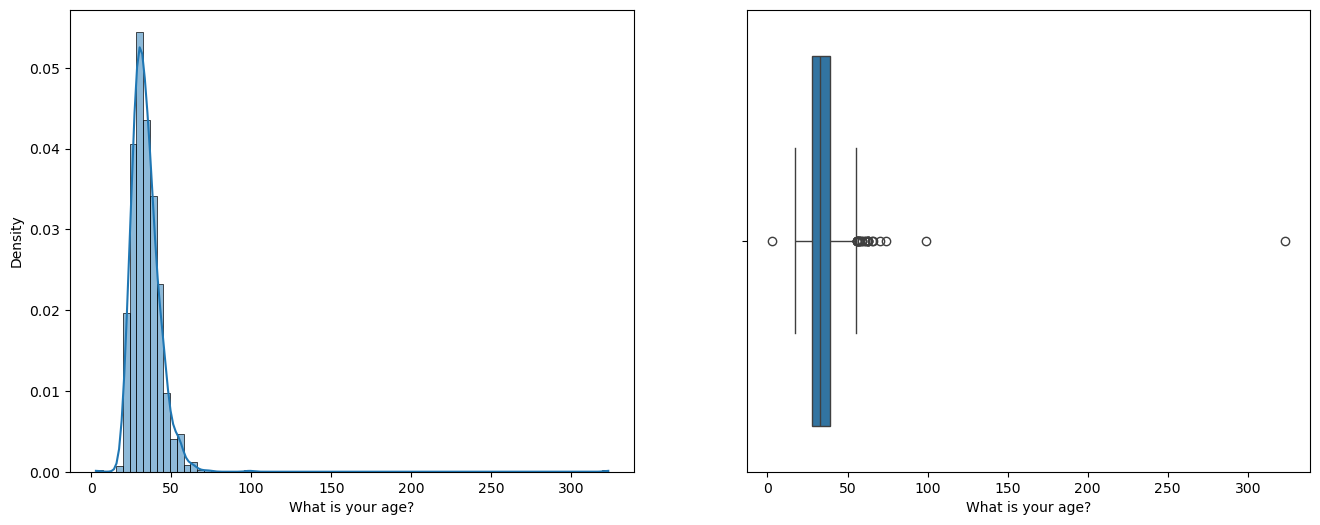

In [51]:
# Explore distribution. Histogram and box plot confirm outliers
fig, axs = plt.subplots(figsize=(16,6), nrows=1, ncols=2)
sns.histplot(data=df, x="What is your age?", stat="density", kde=True, ax=axs[0])
sns.boxplot(data=df, x="What is your age?", ax=axs[1])

In [52]:
# the age of the outliers will be imputed with the median
# any age that is larger than q75 + 1.5*iqr or q25 - 1.5*iqr will be considered an outlier
q25, q75 = np.quantile(df["What is your age?"], [.25, .75])
iqr = q75 - q25
iqr

np.float64(11.0)

In [53]:
upper_limit = q75 + (1.5 * iqr)
lower_limit = q25 - (1.5 * iqr)

In [54]:
upper_limit

np.float64(55.5)

In [55]:
lower_limit

np.float64(11.5)

In [56]:
df.loc[:,["What is your age?"]][(df["What is your age?"] > upper_limit) | (df["What is your age?"] < lower_limit)].shape

(26, 1)

In [57]:
# Proportion of imputed ages -> low impact on the dataset
26/1413

0.01840056617126681

In [58]:
df["What is your age?"] = df["What is your age?"].apply(lambda age: df["What is your age?"].median() if age > upper_limit or age < lower_limit else age)

In [59]:
# Sanity check
# How many unique answers with and without nans? Are theere any questions that still requiere special attention?
unique_vals_with_nan = df.nunique(dropna=False)
unique_vals_with_nan.name = "with_nan"

unique_vals_without_nan = df.nunique(dropna=True)
unique_vals_without_nan.name = "without_nan"

pd.merge(unique_vals_with_nan, unique_vals_without_nan, left_index=True, right_index=True)

,with_nan,without_nan
Are you self-employed?,2,2
How many employees does your company or organization have?,7,6
Is your employer primarily a tech company/organization?,3,2
Does your employer provide mental health benefits as part of healthcare coverage?,5,4
Do you know the options for mental health care available under your employer-provided coverage?,4,3
"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",4,3
Does your employer offer resources to learn more about mental health concerns and options for seeking help?,4,3
Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,4,3
"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",7,6
Do you think that discussing a mental health disorder with your employer would have negative consequences?,4,3


### Overview of the whole dataset.

Is everything clean? Are there any more questions that requiere special attention and standardization?

In [60]:
for col in df.columns:
    print(df[col].value_counts(dropna=False))
    print()

Are you self-employed?
0    1146
1     267
Name: count, dtype: int64

How many employees does your company or organization have?
26-100            292
NaN               267
More than 1000    256
100-500           248
6-25              210
500-1000           80
1-5                60
Name: count, dtype: int64

Is your employer primarily a tech company/organization?
1.0    883
NaN    267
0.0    263
Name: count, dtype: int64

Does your employer provide mental health benefits as part of healthcare coverage?
Yes                                531
I don't know                       319
NaN                                267
No                                 213
Not eligible for coverage / N/A     83
Name: count, dtype: int64

Do you know the options for mental health care available under your employer-provided coverage?
NaN              400
No               354
I am not sure    352
Yes              307
Name: count, dtype: int64

Has your employer ever formally discussed mental health (for ex

### Are you self-employed

Missing answers in some of the questions are not random, they are the consequence of the first question.  
For self-employed people some of the question simply do not apply so they were left unanswered, in this case missingness provides structure. This can be a potential feature for the clusters

In [61]:
# observing a smallsubset of the self employed participants
df[df["Are you self-employed?"] == 1].head(10)

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,Which of the following best describes your work position?,Do you work remotely?
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Some did,N/A (not c

In [72]:
df.loc[:, 
    ["Do you have previous employers?", "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?"]][df["Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?"].isna()]

,Do you have previous employers?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
24,1,NaN
52,1,NaN
65,1,NaN
90,1,NaN
94,1,NaN
100,1,NaN
122,1,NaN
152,0,NaN
158,1,NaN
166,1,NaN


# Dealing with missing values

During the exploration of the dataset it was detected that the missing values observed ar not Missing At Random, they are the consequence of how the survey has beed structured.  
For example, the question "Are you self employed?" Revealed that 267 people are indeed self-employed which has an impact on following questions about their current work place such as:  

- How many employees does your company or organization have?
- Is your employer primarily a tech company/organization?
- Does your employer provide mental health benefits as part of healthcare coverage?
- etc.

There are 13 questions that are directly affected by this first question.

Similarly, for the question: _Do you have previous employers?_, there are 149 people who do not have previous employers and some of them overlap with the people who are self-employed.  
This indicates some normal career paths where people might have started a bussiness or do freelancing.

Missing values will be encoded with a new category depending on the question.

In [62]:
# Check how many missing values per question after standardizing answers
df.isna().sum()

Are you self-employed?                                                                                                                              0
How many employees does your company or organization have?                                                                                        267
Is your employer primarily a tech company/organization?                                                                                           267
Does your employer provide mental health benefits as part of healthcare coverage?                                                                 267
Do you know the options for mental health care available under your employer-provided coverage?                                                   400
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?            267
Does your employer offer resources to learn more about mental health concerns and options for seekin

In [73]:
# We use the NA category to replace missing values in the text columns
na_questions = [
    "How many employees does your company or organization have?",
    "Does your employer provide mental health benefits as part of healthcare coverage?",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?",
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?",
    "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?",
    "Do you think that discussing a physical health issue with your employer would have negative consequences?",
    "Would you feel comfortable discussing a mental health disorder with your coworkers?",
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?",
    "Do you feel that your employer takes mental health as seriously as physical health?",
    "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?",
    "Have your previous employers provided mental health benefits?",
    "Were you aware of the options for mental health care provided by your previous employers?",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?",
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?",
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?",
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?",
    "Would you have been willing to discuss a mental health issue with your previous co-workers?",
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?",
    "Did you feel that your previous employers took mental health as seriously as physical health?",
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?"
]

# We use the category 2 to encode NA for the columns that are already numeric
na_questions_numeric = [
    "Is your employer primarily a tech company/organization?",
    "Do you have previous employers?",
]

# It is difficult to associate this question with the NA -Not applicable- category since there are 400 NaN,i.e., unanswered questions
# Use the Unknown category to replace the missing values
# It is important to keep it, 71% of people answered it
unknown_questions = [
    "Do you know the options for mental health care available under your employer-provided coverage?",
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?"
]

In [74]:
# imputation
text_imputer = SimpleImputer(strategy="constant", fill_value="NA")
df.loc[:, na_questions] = text_imputer.fit_transform(df.loc[:, na_questions].copy())

numeric_imputer = SimpleImputer(strategy="constant", fill_value=2)
df.loc[:, na_questions_numeric] = numeric_imputer.fit_transform(df.loc[:, na_questions_numeric].copy())

unknown_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
df.loc[:, unknown_questions] = unknown_imputer.fit_transform(df.loc[:, unknown_questions].copy())

gender_imputer = SimpleImputer(strategy="most_frequent")
df.loc[:, "What is your gender?"] = gender_imputer.fit_transform(df.loc[:, ["What is your gender?"]])

In [75]:
df.nunique()

Are you self-employed?                                                                                                                             2
How many employees does your company or organization have?                                                                                         7
Is your employer primarily a tech company/organization?                                                                                            3
Does your employer provide mental health benefits as part of healthcare coverage?                                                                  5
Do you know the options for mental health care available under your employer-provided coverage?                                                    4
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?             4
Does your employer offer resources to learn more about mental health concerns and options for seeking help

In [76]:
df.to_csv(LOCATION_DATSET.parent.joinpath("osmi_mental_health_clean.csv"))